In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('./resources/DATA/RSCCASN.csv', parse_dates=True, index_col='DATE')

In [4]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [5]:
df.columns = ['Sales']

In [6]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


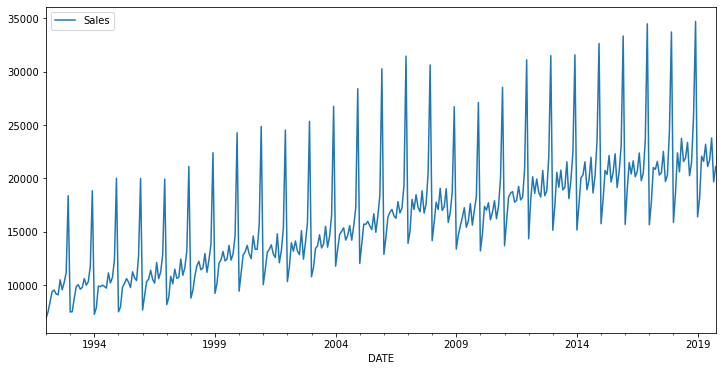

In [11]:
df.plot(figsize=(12, 6));

In [12]:
len(df)

334

In [13]:
test_size = 18
test_index = len(df) - test_size

In [14]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [15]:
len(test) + len(train)

334

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()

scaler.fit(train)

MinMaxScaler()

In [18]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [22]:
X, y = generator[0]

In [23]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [25]:
n_features = 1

In [26]:
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [29]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [30]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [32]:
model.fit_generator(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 94s 308ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 2/20
304/304 [==============================] - 90s 297ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 3/20
304/304 [==============================] - 104s 341ms/step - loss: 0.0023 - val_loss: 6.6577e-04
Epoch 4/20
304/304 [==============================] - 102s 335ms/step - loss: 0.0016 - val_loss: 0.0070
Epoch 5/20
304/304 [==============================] - 106s 350ms/step - loss: 0.0015 - val_loss: 0.0012


<AxesSubplot:>

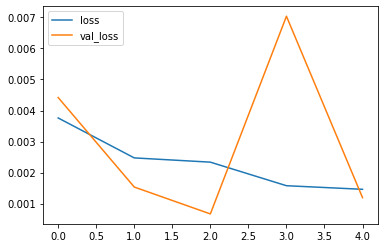

In [33]:
losses = pd.DataFrame(model.history.history)

losses.plot()

In [34]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [35]:
true_preds = scaler.inverse_transform(test_predictions)

In [36]:
test['Predictions'] = true_preds

/Users/loic.combis/Desktop/workspace/tf-bootcamp/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


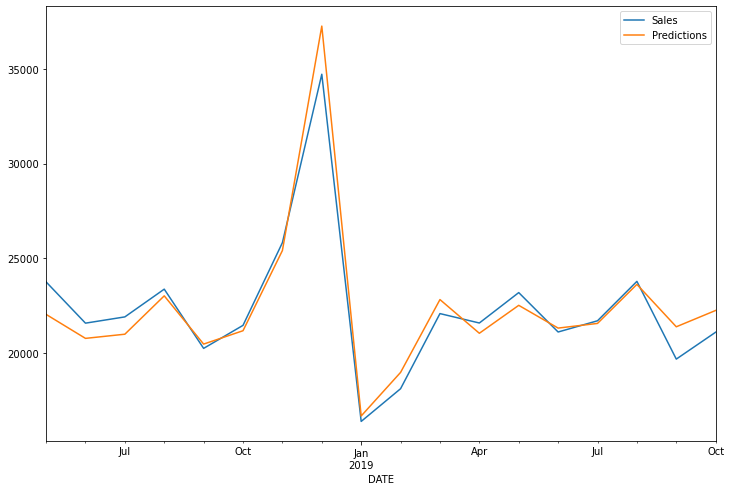

In [38]:
test.plot(figsize=(12, 8));

In [39]:
full_scaler = MinMaxScaler()

scaled_full_data = full_scaler.fit_transform(df)

In [43]:
length=12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [44]:
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [45]:
model.fit_generator(generator, epochs=3)

Epoch 1/3
322/322 [==============================] - 96s 299ms/step - loss: 0.0270
Epoch 2/3
322/322 [==============================] - 95s 295ms/step - loss: 0.0143
Epoch 3/3
322/322 [==============================] - 88s 275ms/step - loss: 0.0094


In [46]:
forecast = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
periods = 12

for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [47]:
forecast = full_scaler.inverse_transform(forecast)

In [49]:
forecast_index = pd.date_range(start='2019-11-01', periods=periods, freq='MS')

In [50]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [51]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index, columns=['Forecast'])

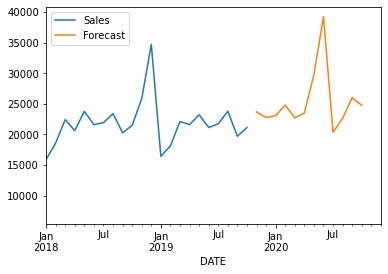

In [53]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01', '2020-12-01');